In [1]:
import os
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import joblib

In [6]:
# DATA
df1 = pd.read_csv('data_day.csv')
df2 = pd.read_csv('data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data_2004-11-26_to_2007-08-22.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
df.index = range(0,4996)
df.tail()

date_time = pd.concat([pd.to_datetime(df['datetime'][0:4000]),pd.to_datetime(df['datetime'][4000:])])
data_use = df[['temp','tempmax', 'tempmin','humidity', 'precip', 'windspeed', 'solarradiation', 'solarenergy']]
print(data_use)

      temp  tempmax  tempmin  humidity  precip  windspeed  solarradiation  \
0     30.8     36.5     26.0      78.1   0.000       20.5           301.4   
1     31.3     36.4     27.0      76.0   0.300       24.1           281.5   
2     30.7     39.0     26.0      76.1   2.300       40.7           237.1   
3     31.5     39.6     26.0      71.2   0.800       15.1           296.8   
4     27.6     30.8     25.8      80.1  33.000       22.7           240.8   
...    ...      ...      ...       ...     ...        ...             ...   
4991  20.5     22.0     19.5      93.8   8.794       17.5           148.7   
4992  22.4     26.5     20.0      84.5   0.683       19.4           140.8   
4993  22.6     26.6     20.0      85.5   0.072       20.3           131.9   
4994  23.0     26.0     19.0      82.4   3.300       20.5            63.7   
4995  16.0     18.0     14.0      91.4   3.400       22.3            15.8   

      solarenergy  
0            26.1  
1            24.3  
2            20

In [7]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[1] - timestamp_s[0]

86400.0

C:\Users\tridu\AppData\Local\Temp\ipykernel_13580\1206436225.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
C:\Users\tridu\AppData\Local\Temp\ipykernel_13580\1206436225.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Index(['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 'windspeed',
       'solarradiation', 'solarenergy', 'Year sin', 'Year cos'],
      dtype='object')

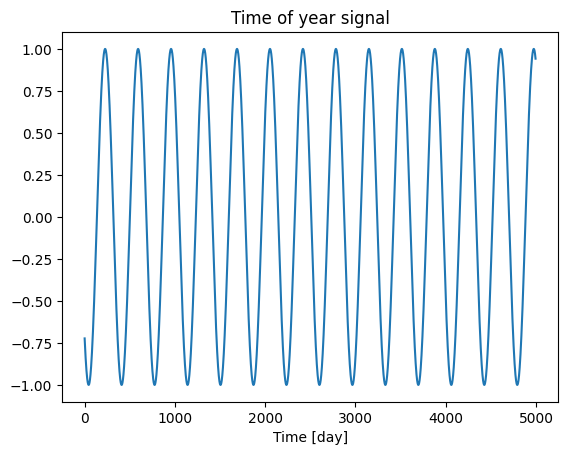

In [8]:
# PERIOD TIME

day = 24*60*60
year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(data_use['Year cos'])[:])
plt.xlabel('Time [day]')
plt.title('Time of year signal')
data_use.columns

In [9]:
number_train = int(data_use.shape[0] * 0.8)
train, test = data_use[0:number_train], data_use[number_train:]

In [10]:
def create_data(in_steps, out_steps, data, features):
    X = []
    y = []
    for i in range(len(data)-in_steps-out_steps):
        X.append(data[i:i+in_steps])
        y.append(data[i+in_steps:i+in_steps+out_steps][features])
    return np.array(X), np.array(y)
def normalize(data, train_mean, train_std):
    data_norm = (data - train_mean)/train_std
    return data_norm
def unnormalize(data, train_mean, train_std):
    data_unnorm = (data * train_std) + train_mean
    return data_unnorm

In [11]:
in_steps = 365
out_steps = 7
features_train = ['temp']
num_features = len(features_train) 

In [12]:
X_train, y_train = create_data(in_steps, out_steps, train, features_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], num_features)

X_test, y_test = create_data(in_steps, out_steps, test, features_train)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], num_features)

X_train_norm = normalize(X_train, X_train.mean(), X_train.std())
y_train_norm = normalize(y_train, y_train.mean(), y_train.std())

X_test_norm = normalize(X_test, X_train.mean(), X_train.std())
y_test_norm = normalize(y_test, y_train.mean(), y_train.std())

print(X_train_norm.shape, y_train_norm.shape, X_test_norm.shape, y_test_norm.shape)


(3624, 365, 10) (3624, 7, 1) (628, 365, 10) (628, 7, 1)


In [9]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [10]:
model.fit(X_train_norm.reshape(X_train_norm.shape[0], X_train_norm.shape[1]*X_train_norm.shape[2]), y_train_norm.reshape(y_train_norm.shape[0], y_train_norm.shape[1]*y_train_norm.shape[2]))

RandomForestRegressor(random_state=42)

In [14]:
joblib.dump(model, 'model_rf-365-7.pkl')

['model_rf-365-7.pkl']

In [13]:
model_recall = joblib.load('model_rf-365-7.pkl') 

In [14]:
predictions = model_recall.predict(X_test_norm.reshape(X_test_norm.shape[0], X_test_norm.shape[1]*X_test_norm.shape[2]))
predictions = predictions.reshape(predictions.shape[0], out_steps, num_features)

Day:  1
MAE:  1.3379888535031847
MSE:  2.9766947308917193
CORR:  0.9319647293568042
Day:  2
MAE:  1.6618439490445858
MSE:  4.455234662420382
CORR:  0.8976198941158184
Day:  3
MAE:  1.8192595541401275
MSE:  5.259828546178344
CORR:  0.8794120809176477
Day:  4
MAE:  1.8902898089171973
MSE:  5.657305006369427
CORR:  0.871574554732568
Day:  5
MAE:  1.9352914012738855
MSE:  5.922749527070064
CORR:  0.8670984695284083
Day:  6
MAE:  1.9620031847133756
MSE:  6.111934073248408
CORR:  0.8643046027128595
Day:  7
MAE:  1.9501226114649683
MSE:  6.117220578025477
CORR:  0.8648545243797401


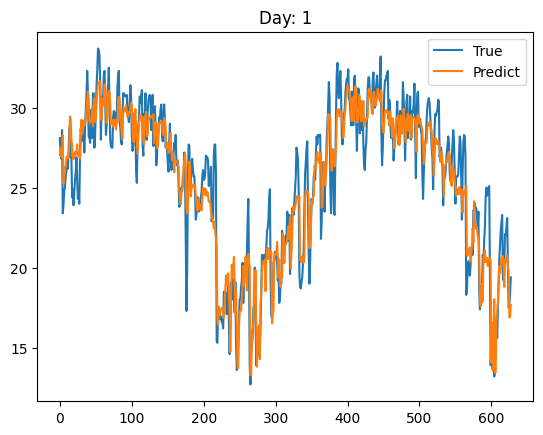

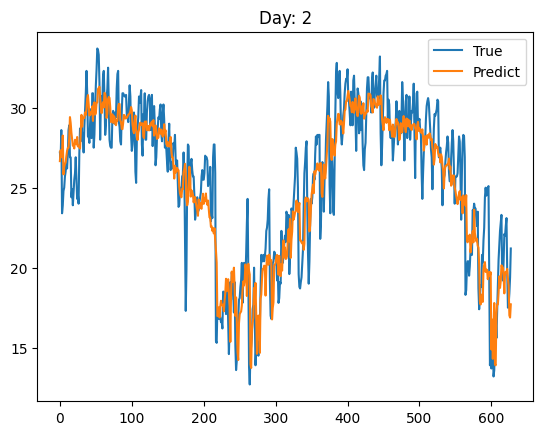

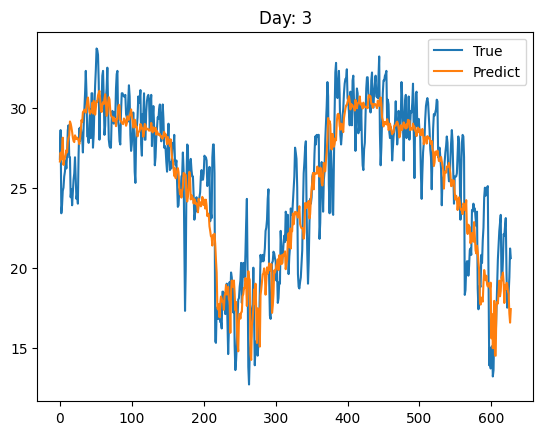

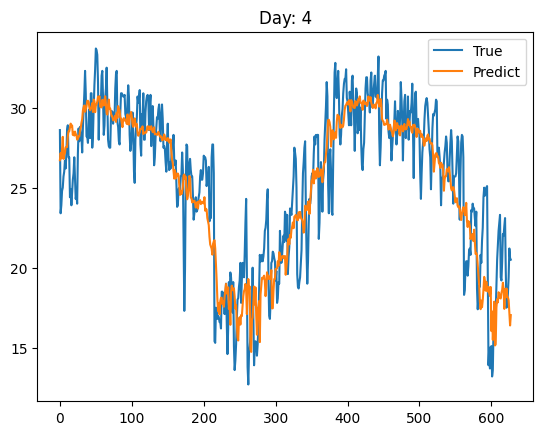

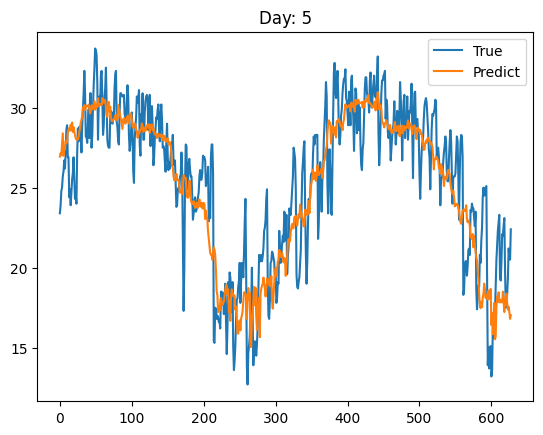

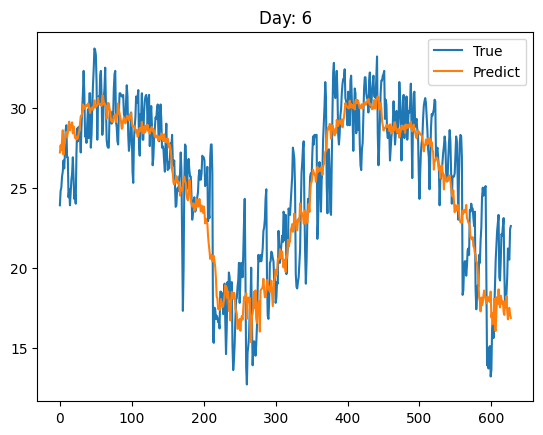

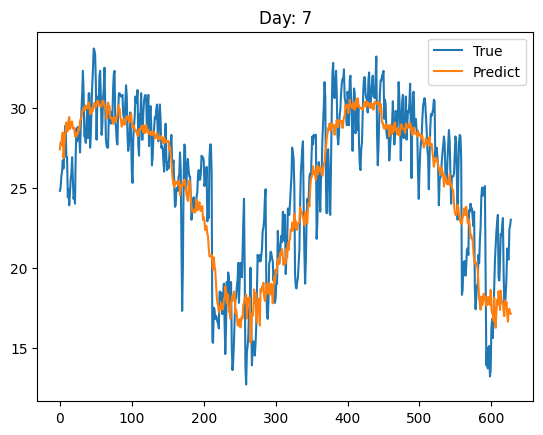

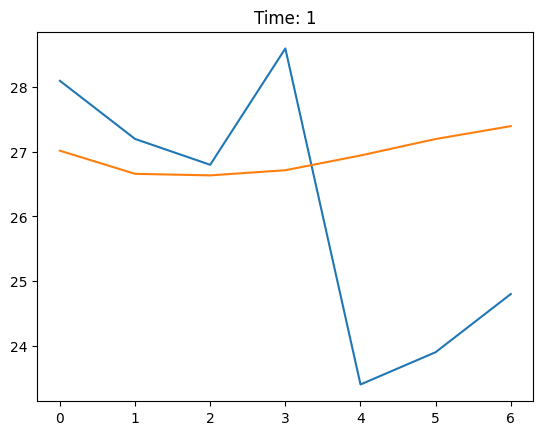

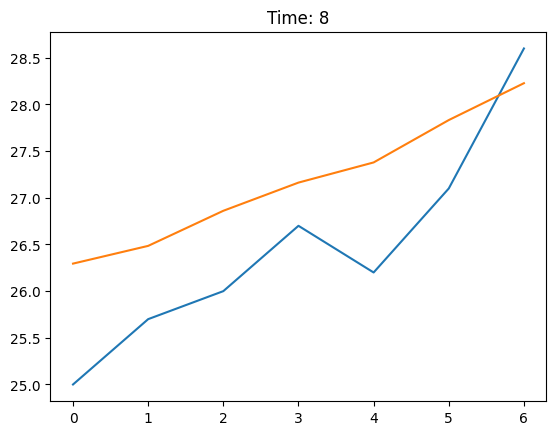

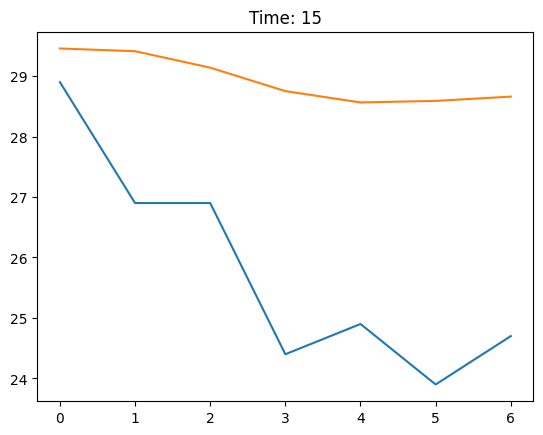

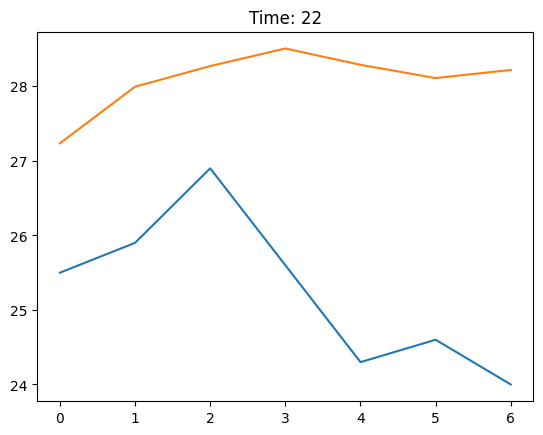

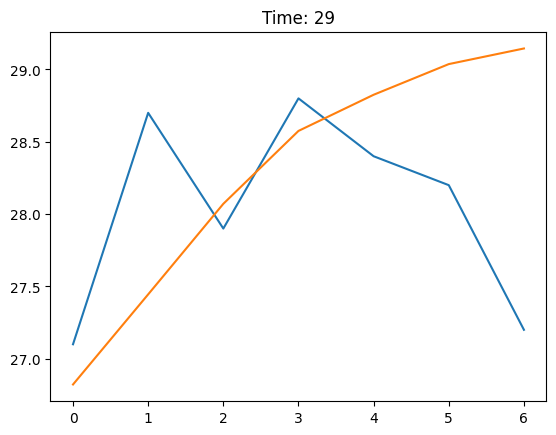

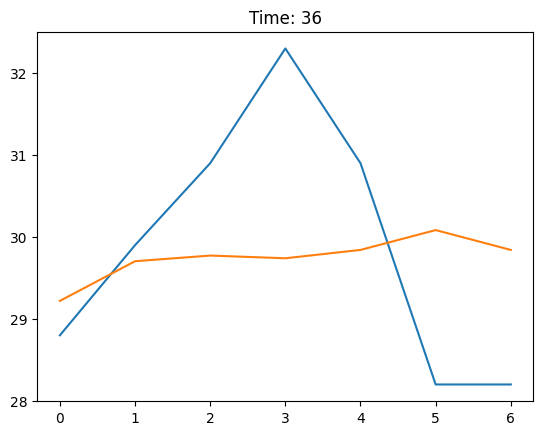

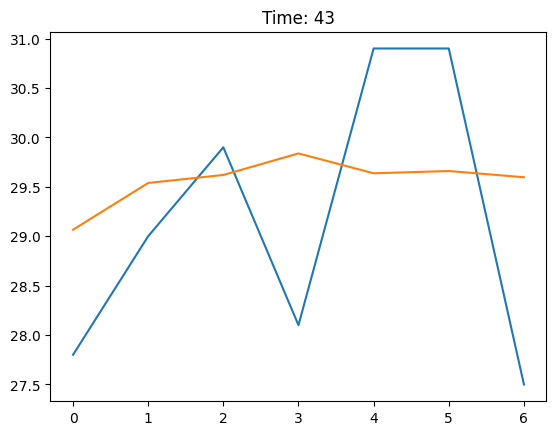

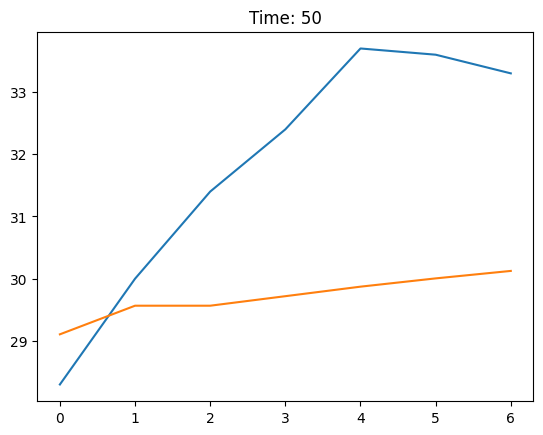

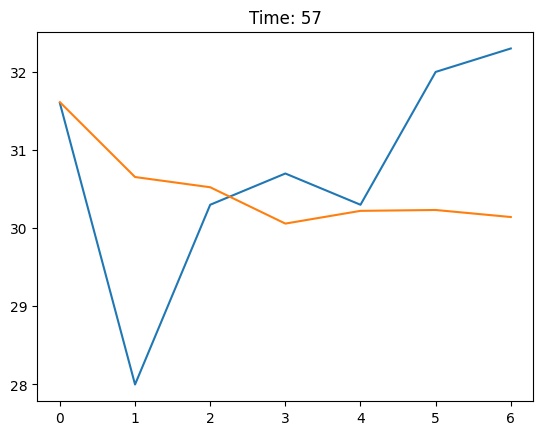

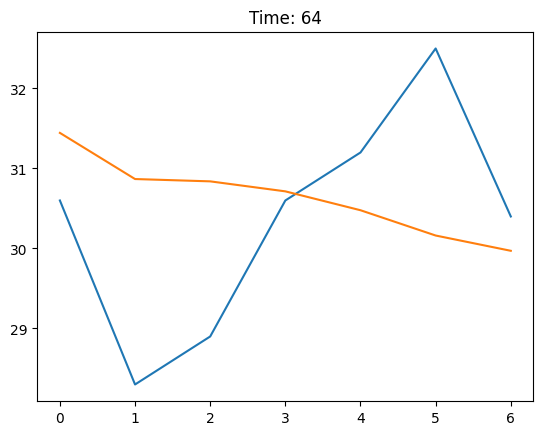

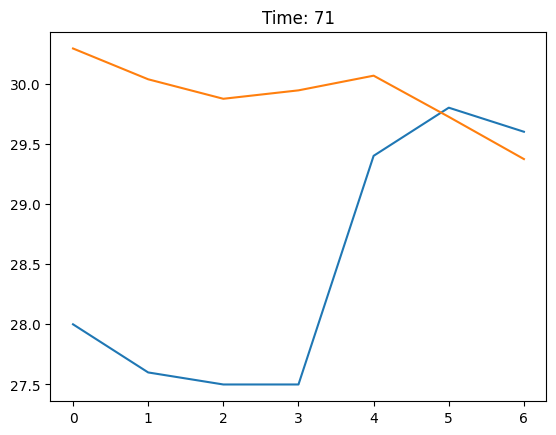

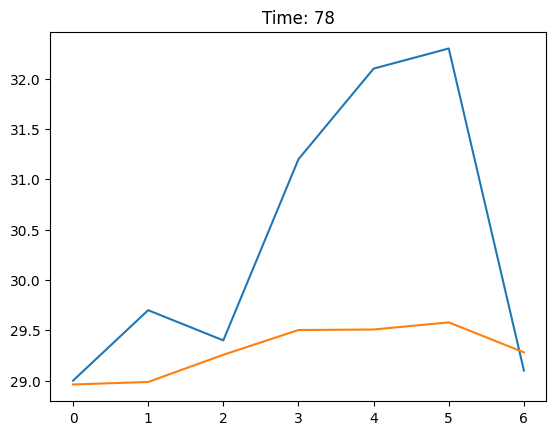

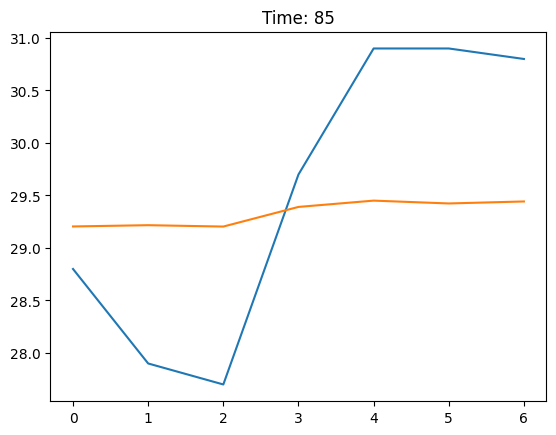

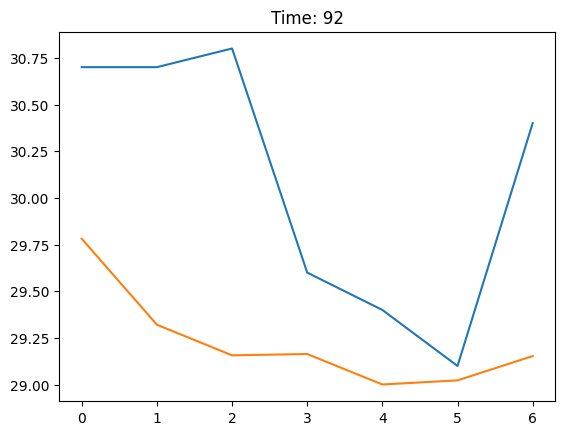

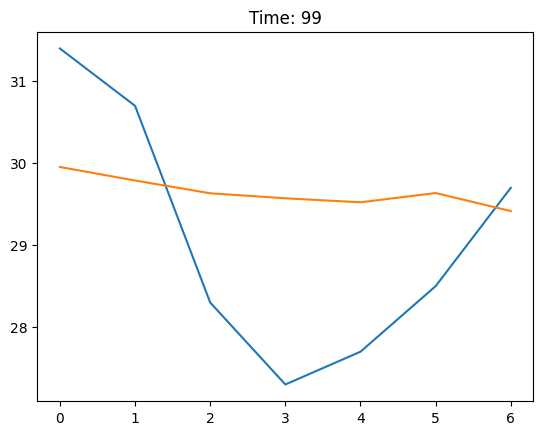

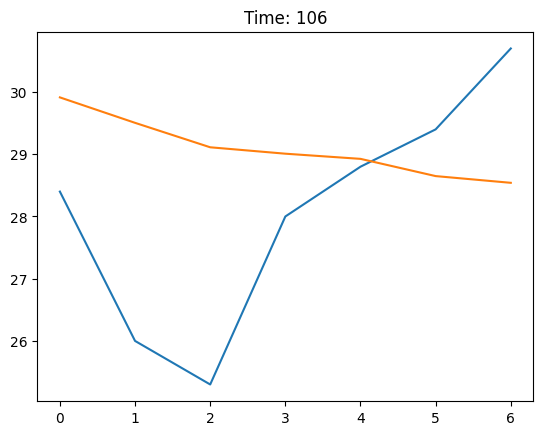

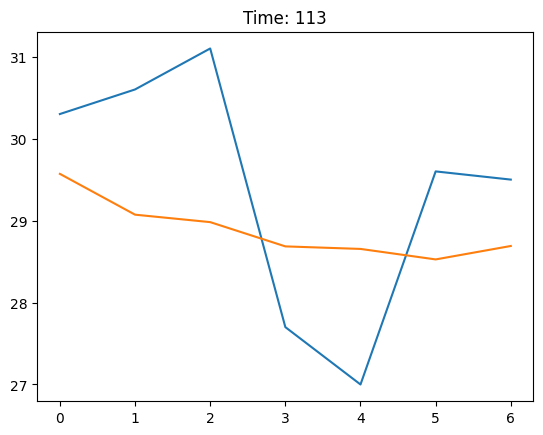

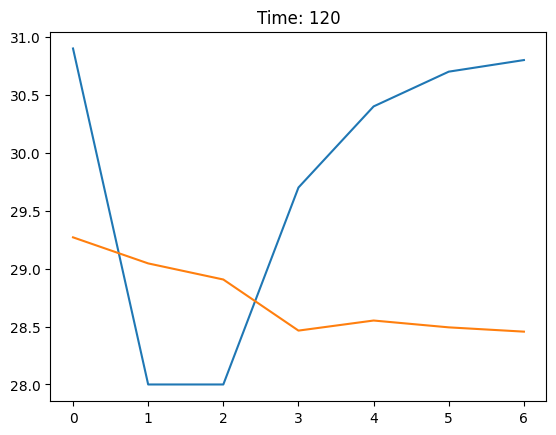

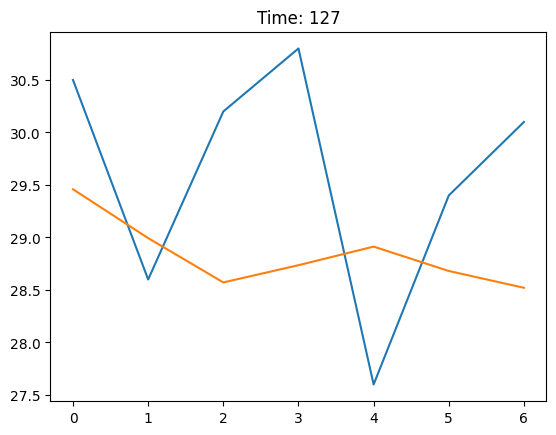

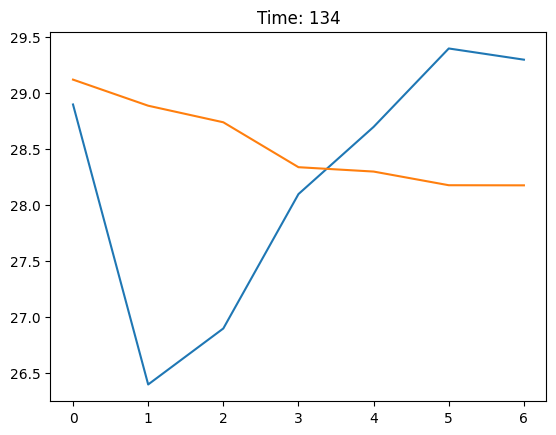

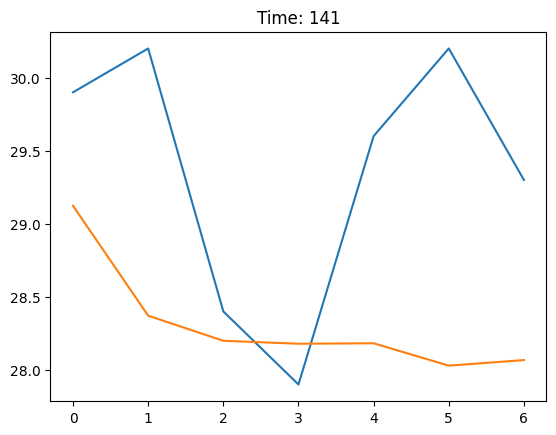

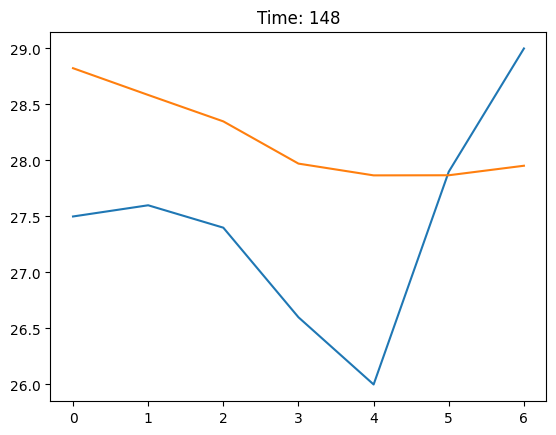

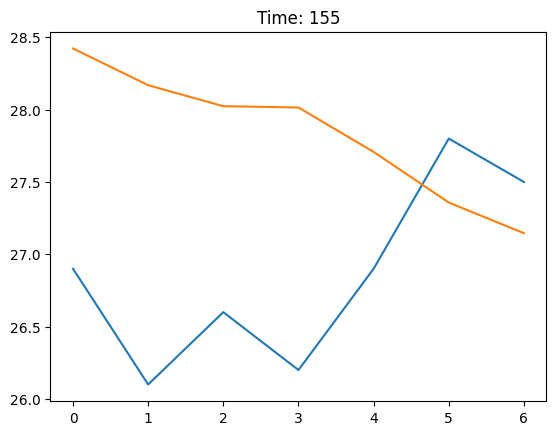

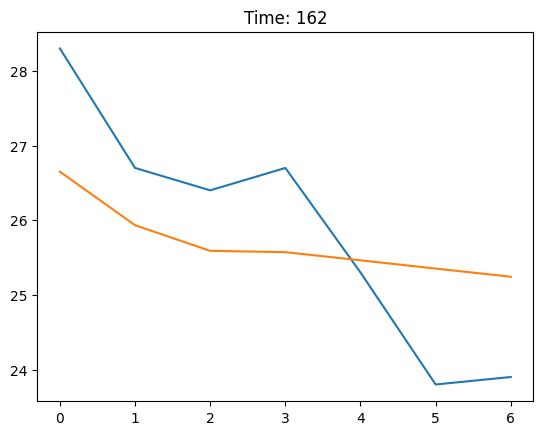

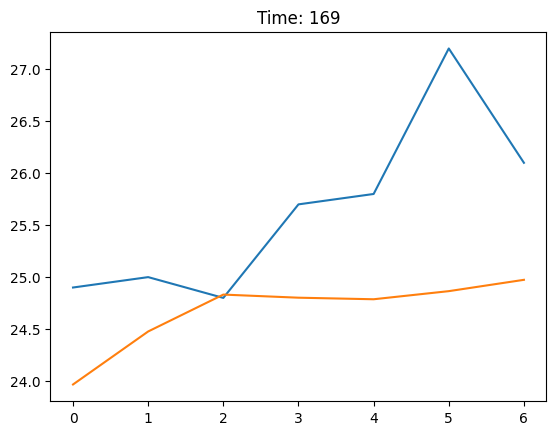

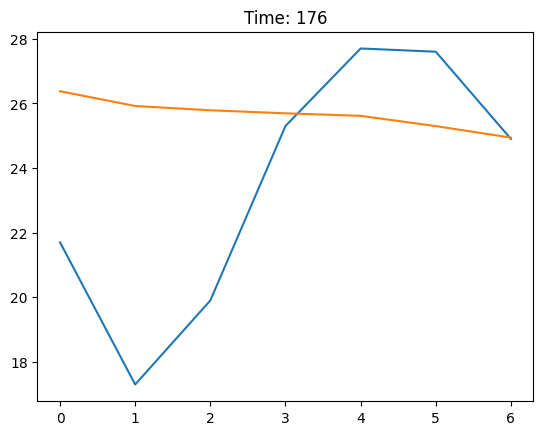

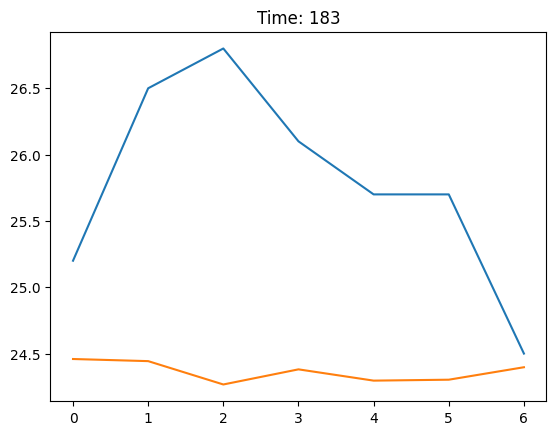

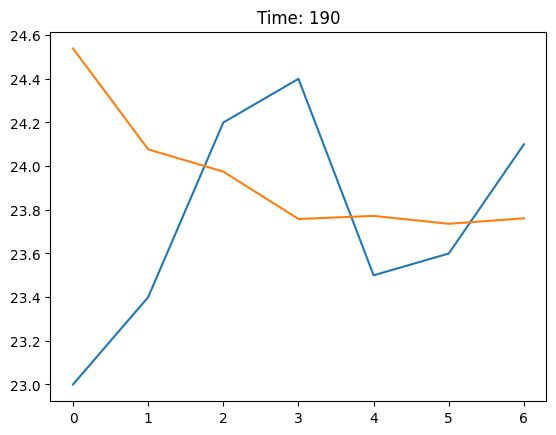

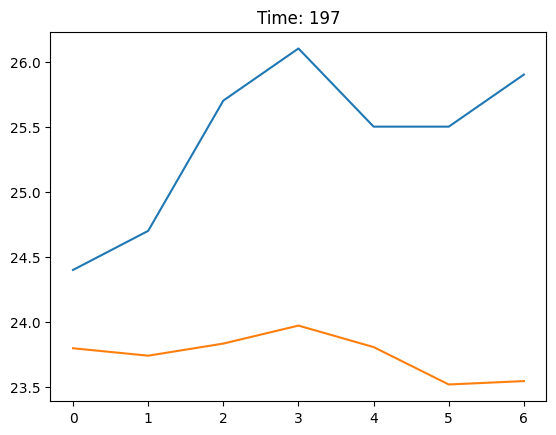

In [15]:
feature = 0
predict_unnorm = unnormalize(predictions, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
for i in range(7):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature])[0,1])
for i in range(7):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,feature])
    plt.plot(predict_unnorm[:,i,feature])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, 7):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,feature])
    plt.plot(predict_unnorm[i,:,feature])
    plt.show()
    